### Kinematic Single-track Dynamics Example

This notebook will lay out an example of using data collected from simulation of the F1/10 cars to create models for the car's behavior

In [1]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, labs

In [2]:
def import_csv(filenum: int, filename: str):
    input_df = pd.read_csv(f"csv/in_{filename}_{filenum}.csv")
    obs_df = pd.read_csv(f"csv/obs_{filename}_{filenum}.csv")
    deriv_df = pd.read_csv(f"csv/deriv_{filename}_{filenum}.csv")
  
    return obs_df[['time', 'x', 'y', 'steering_angle', 'velocity', 'heading']], input_df[['time', 'steering_velocity', 'acceleration']], deriv_df

num_files = 3
obs = []
inputs = []
derivs = []

for i in range(num_files):
    return_val = import_csv(i, 'kinematic')

    obs.append(return_val[0])
    inputs.append(return_val[1])
    derivs.append(return_val[2])

states_df = obs[1]
input_df = inputs[1]
deriv_df = derivs[1]
states_df

,time,x,y,steering_angle,velocity,heading
0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
1,0.01,-5.025284e-09,-1.160130e-23,-5.688449e-07,-0.000001,5.771465e-15
2,0.02,-2.512642e-08,-7.714865e-22,-1.706535e-06,-0.000003,8.080052e-14
3,0.03,-7.035397e-08,-1.178692e-20,-3.413069e-06,-0.000006,4.444028e-13
4,0.04,-1.507585e-07,-8.933001e-20,-5.688449e-06,-0.000010,1.575610e-12
...,...,...,...,...,...,...
59996,599.96,-7.006661e+01,-5.247942e+01,-4.189716e-01,20.000855,-7.033884e+02
59997,599.97,-6.987093e+01,-5.244107e+01,-4.189716e-01,20.000855,-7.036581e+02
59998,599.98,-6.967211e+01,-5.245626e+01,-4.189716e-01,20.000855,-7.039279e+02
59999,599.99,-6.948452e+01,-5.252388e+01,-4.189716e-01,20.000855,-7.041976e+02


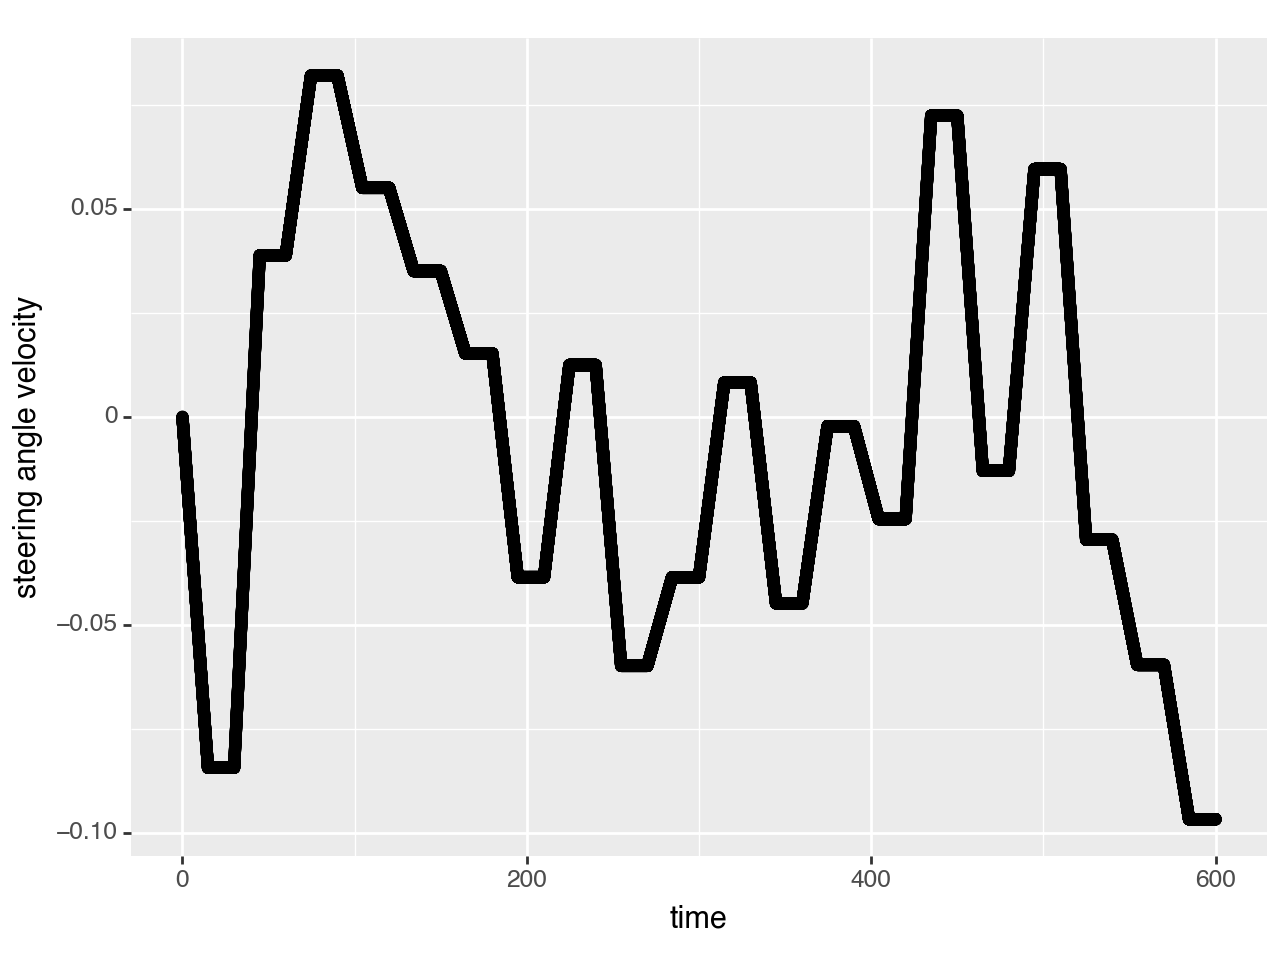

<Figure Size: (640 x 480)>

In [3]:
(
    ggplot(input_df, aes(x='time', y='steering_velocity')) 
    + geom_point() 
    + labs(x="time", y="steering angle velocity")
) 

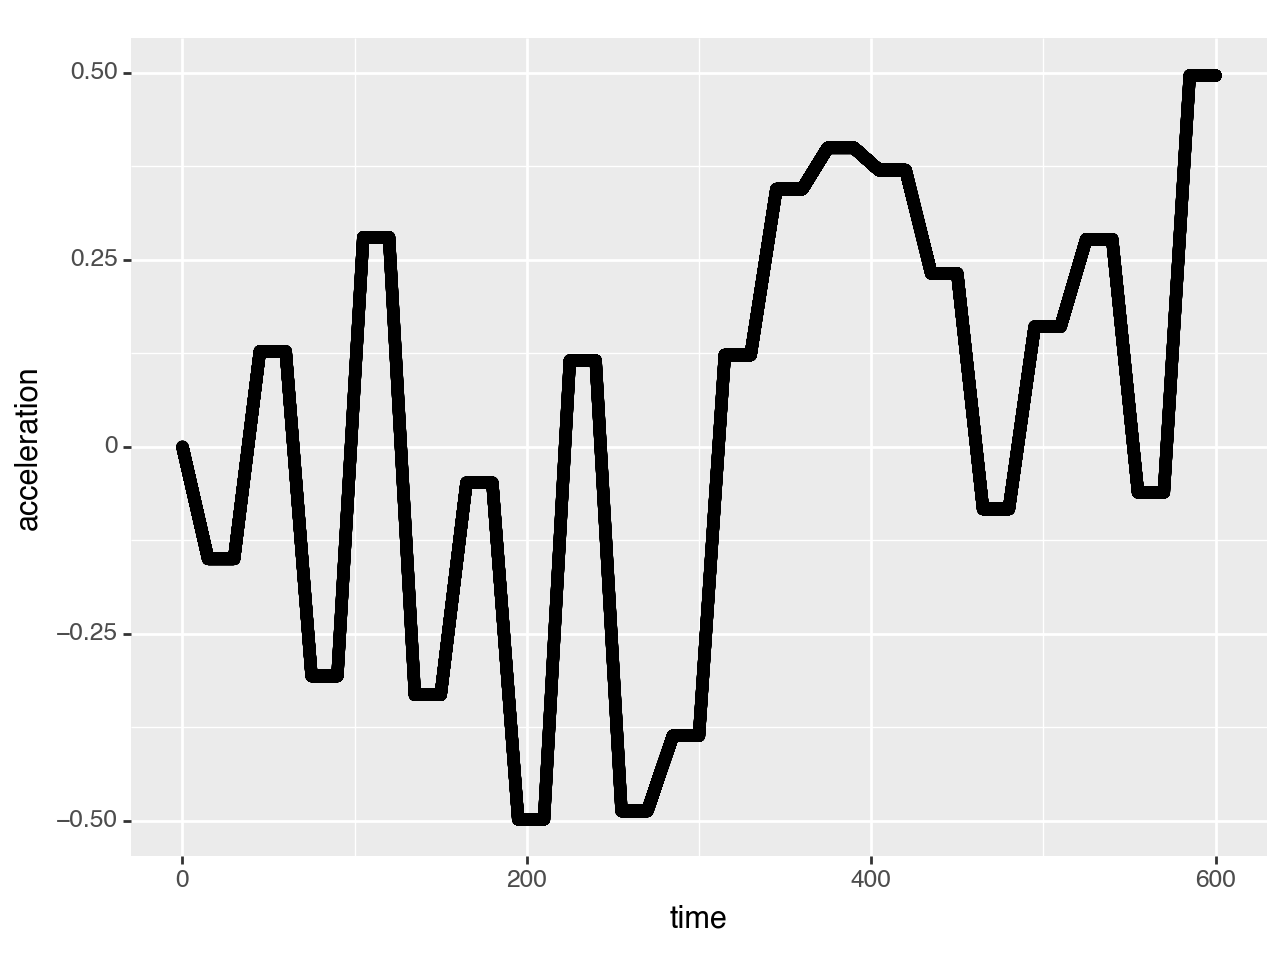

<Figure Size: (640 x 480)>

In [4]:
(
    ggplot(input_df, aes(x='time', y='acceleration')) 
    + geom_point()
    + labs(x="time", y="acceleration")
)

### Physics Model

Our training data has been generated with by a simulator using the following ODE:

$$
\dot{x} = vcos{(\psi)}
$$
$$
\dot{y} = vsin{(\psi)}
$$
$$
\dot{v} = a
$$
$$
\dot{\psi} = \frac{v}{l_{wb}}tan{(\delta)}
$$
$$
\dot{\delta} = v_\delta
$$

More information about these physics can be found [here](https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf?ref_type=heads).

### Neuromancer Setup

We will create a NeuralODE, which will aim to learn these governing equations from the data. To do this, we will use the neuromancer library

In [5]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

In [6]:
n_obs = 60000

train_X = obs[2][:n_obs]
test_X = obs[1][:n_obs]
dev_X = obs[0][:n_obs]


train_U = inputs[2][:n_obs]
test_U = inputs[1][:n_obs]
dev_U = inputs[0][:n_obs]
train_X

,time,x,y,steering_angle,velocity,heading
0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
1,0.01,6.024917e-09,-1.945554e-23,-6.636659e-07,0.000001,-8.072949e-15
2,0.02,3.012458e-08,-1.293793e-21,-1.990998e-06,0.000004,-1.130213e-13
3,0.03,8.434884e-08,-1.976683e-20,-3.981995e-06,0.000007,-6.216171e-13
4,0.04,1.807475e-07,-1.498077e-19,-6.636659e-06,0.000012,-2.203915e-12
...,...,...,...,...,...,...
59995,599.95,-8.033885e+01,-5.009554e+01,-4.190386e-01,10.334391,2.863210e+03
59996,599.96,-8.038106e+01,-5.018976e+01,-4.190386e-01,10.330809,2.863071e+03
59997,599.97,-8.043592e+01,-5.027718e+01,-4.190386e-01,10.327226,2.862932e+03
59998,599.98,-8.050237e+01,-5.035611e+01,-4.190386e-01,10.323643,2.862792e+03


In [7]:
def normalize(x):
        return (x - x.mean(axis=0)) / x.std(axis=0)

nsteps = 2
bs = 50

def get_data(nsteps, bs, dropX, dropU): 

    trainX = train_X.drop(columns=dropX).reset_index(drop=True)
    nbatch = trainX.shape[0]//nsteps
    length = (trainX.shape[0]//nsteps) * nsteps

    nx = trainX.shape[1]
    trainX = trainX.to_numpy()
    trainX = normalize(trainX)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    
    trainU = train_U.drop(columns=dropU).reset_index(drop=True)
    nu = trainU.shape[1]
    trainU = trainU.to_numpy()
    trainU = normalize(trainU)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    
    devX = dev_X.drop(columns=dropX).reset_index(drop=True)
    devX = devX.to_numpy()
    devX = normalize(devX)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    
    devU = dev_U.drop(columns=dropU).reset_index(drop=True)
    devU = devU[:length].to_numpy()
    devU = normalize(devU)
    devU = devU.reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    
    testX = test_X.drop(columns=dropX).reset_index(drop=True)
    testX = testX.to_numpy()
    testX = normalize(testX)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    
    testU = test_U.drop(columns=dropU).reset_index(drop=True)
    testU = testU.to_numpy()
    testU = normalize(testU)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)

    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    
    test_data = {'X': testX, 'xn': testX[:, 0:1, :],
                 'U': testU}

    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    return train_loader, dev_loader, test_data, nx, nu

train_loader, dev_loader, test_data, nx, nu = get_data(nsteps, bs, ['time', 'x', 'y'], ['time'])

In [8]:
fx = blocks.MLP(nx+nu, nx, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=[80, 80, 80])

In [9]:
fxInt = integrators.DiffEqIntegrator(fx, h=0.01, method='euler')

In [10]:
model = Node(fxInt, ['xn', 'U'], ['xn'], name='NODE')
dynamics_model = System([model], name='system', nsteps=nsteps)

In [11]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]
steering = variable('xn')[:, :, [0]]
velocity = variable('xn')[:, :, [1]]

# trajectory tracking loss
reference_loss = 1.*(xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

In [12]:
objectives = [reference_loss, onestep_loss]
constraints = []

loss = PenaltyLoss(objectives, constraints)

problem = Problem([dynamics_model], loss)

In [13]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.0075)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])
# define neuromancer trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=50,
    epochs=2000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    test_metric="test_loss",
    dev_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 13683


In [ ]:
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 0.00000	dev_loss: 0.00000	eltime:  8.76039
epoch: 1	train_loss: 0.00000	dev_loss: 0.00000	eltime:  17.71272
epoch: 2	train_loss: 0.00000	dev_loss: 0.00000	eltime:  27.95316
epoch: 3	train_loss: 0.00000	dev_loss: 0.00000	eltime:  37.94271
epoch: 4	train_loss: 0.00000	dev_loss: 0.00000	eltime:  47.78461
epoch: 5	train_loss: 0.00000	dev_loss: 0.00000	eltime:  57.53450
epoch: 6	train_loss: 0.00000	dev_loss: 0.00000	eltime:  67.21829
epoch: 7	train_loss: 0.00000	dev_loss: 0.00000	eltime:  76.80809
epoch: 8	train_loss: 0.00000	dev_loss: 0.00000	eltime:  86.86240
epoch: 9	train_loss: 0.00000	dev_loss: 0.00000	eltime:  96.46176
epoch: 10	train_loss: 0.00000	dev_loss: 0.00000	eltime:  106.40285
epoch: 11	train_loss: 0.00000	dev_loss: 0.00000	eltime:  116.27410
epoch: 12	train_loss: 0.00000	dev_loss: 0.00000	eltime:  126.39870
epoch: 13	train_loss: 0.00000	dev_loss: 0.00000	eltime:  136.76346
epoch: 14	train_loss: 0.00000	dev_loss: 0.00000	eltime:  147.18718
epoch: 15	train_

In [ ]:
dynamics_model.nsteps = test_data['X'].shape[1]

In [ ]:
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :].detach().numpy().reshape(-1, nx)
true_traj = test_data['X'].detach().numpy().reshape(-1, nx)
input_traj = test_data['U'].detach().numpy().reshape(-1, nu)

In [ ]:
true_df = pd.DataFrame(data=true_traj)
true_df = true_df.rename(columns={0: 'steering_angle', 1: 'velocity', 2: 'heading'})
true_df = true_df.assign(time=obs[1][['time']][:n_obs].values)
true_df = true_df.assign(source="observed")

pred_df = pd.DataFrame(data=pred_traj)
pred_df = pred_df.rename(columns={0: 'steering_angle', 1: 'velocity', 2: 'heading'})
pred_df = pred_df.assign(time=obs[1][['time']][:n_obs].values)
pred_df = pred_df.assign(source="node")

In [ ]:
combined_df = pd.concat([true_df, pred_df])

combined_df

In [ ]:
(ggplot(combined_df, aes(x='time', y='velocity', color='source')) +
 geom_point())

In [ ]:
(ggplot(combined_df, aes(x='time', y='steering_angle', color='source')) +
 geom_point())

In [ ]:
(ggplot(combined_df, aes(x='time', y='heading', color='source')) +
 geom_point())

### SINDy

Next, we are going to use Sparse Identification of Nonlinear Dynamics to learn the governing equations for this system

In [ ]:
from pysindy.feature_library import FourierLibrary, PolynomialLibrary
from pysindy.feature_library import GeneralizedLibrary, CustomLibrary, ConcatLibrary
import pysindy as ps

In [ ]:
lib_fourier = FourierLibrary()
lib_polynomial = PolynomialLibrary()
lib_concat = ConcatLibrary([lib_fourier, lib_polynomial])

model = ps.SINDy(feature_library = lib_concat)

t = train_X[['time']].to_numpy()

In [ ]:
x = train_X.drop(columns=["time", 'x', 'y']).to_numpy()
u = train_U.drop(columns=["time"])
x = normalize(x)
u = u.to_numpy()
u = normalize(u)
xdot = derivs[2][:n_obs].drop(columns=["time", 'x', 'y']).to_numpy()
xdot = normalize(xdot)

In [ ]:
t.flatten()

In [ ]:
model.fit(x, t, xdot, u)
model.coefficients()

model.print()

In [ ]:
x = test_X.drop(columns=["time", 'x', 'y']).to_numpy()
u = test_U.drop(columns=["time"])
x = normalize(x)
u = u.to_numpy()
u = normalize(u)
xdot = derivs[2][:n_obs].drop(columns=["time", 'x', 'y']).to_numpy()
xdot = normalize(xdot)

xmodel = model.simulate(x[0,:], t.flatten(), u)

In [ ]:
sindy_df = pd.DataFrame(data=xmodel)
sindy_df = sindy_df.assign(time=t[0:-1])
sindy_df = sindy_df.rename(columns={0: 'steering_angle', 1: 'velocity', 2: 'heading'})
sindy_df = sindy_df.assign(source='sindy')

In [ ]:
sindy_df

In [ ]:
combined_df = pd.concat([true_df, sindy_df])

combined_df

In [ ]:
(ggplot(combined_df, aes(x='time', y='heading', color='source')) +
 geom_point())

In [ ]:
(ggplot(train_X, aes(x='time', y='heading')) +
 geom_point())